In [1]:
import os
import pandas as pd
import numpy as np
from UsefulFunctionsForModels import *
from scipy.optimize import minimize, linear_sum_assignment
from PlotsProject import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
path='price_history/high_sales'

In [6]:
df=get_dataframe_cards_matrix(path)
df

/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.p

Error reading card swsh11-199_Holofoil: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte


/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.p

,card_id,last_price,mean_return,Quantity Sold
0,swsh10tg-TG20_Holofoil,6.08,0.03,1379
1,swsh6-174_Holofoil,43.37,-0.02,359
2,xyp-XY113_Holofoil,10.55,-0.08,112
3,dpp-DP01_Holofoil,5.89,-0.00,24
4,sv3-205_Holofoil,6.95,-0.18,3951
...,...,...,...,...
276,swsh5-155_Holofoil,133.21,-0.03,425
277,sv4-253_Holofoil,33.49,0.02,2042
278,sv4-206_Holofoil,10.85,-0.04,1458
279,sv4pt5-132_Holofoil,8.24,NaN,1372


In [93]:
import os
import pandas as pd
import numpy as np
from typing import Dict, Any
from dataclasses import dataclass

@dataclass
class SigmoidParameters:
    MAX_K: float = 1
    MIN_K: float = 0.1
    
    MAX_X0: float = 300
    MIN_X0: float = 10

class MarkowitzOptimizer:
    def __init__(self, 
                 amount_to_invest: float, 
                 dataframe_cards_info: pd.DataFrame, 
                 critical_sales_threshold: float, 
                 sales_volume_sensitivity: float):
        """
        Initialize the Markowitz Optimizer
        
        Args:
            amount_to_invest: Total investment amount
            dataframe_cards_info: DataFrame containing card information
            critical_sales_threshold: Threshold for sales (x0)
            sales_volume_sensitivity: Sensitivity parameter (k)
        """
        self.amount_to_invest = amount_to_invest
        self.df = dataframe_cards_info[['card_id', 'last_price', 'mean_return', 'Quantity Sold']].copy()        
        self.critical_sales_threshold = critical_sales_threshold
        self.sales_volume_sensitivity = sales_volume_sensitivity
        self.params = SigmoidParameters()
    
    @staticmethod
    def sigmoid(x: np.ndarray, x0: float, k: float) -> np.ndarray:
        """Calculate sigmoid function values"""
        return 1 / (1 + np.exp(-k * (x - x0)))
    
    def calculate_parameters(self) -> Dict[str, float]:
        """Calculate k and x0 parameters based on sensitivity"""
        k = (self.params.MAX_K - self.params.MIN_K) * self.sales_volume_sensitivity + self.params.MIN_K
        x0 = (self.params.MAX_X0 - self.params.MIN_X0) * self.critical_sales_threshold + self.params.MIN_X0
        print(k,x0)
        return {"k": k, "x0": x0}
    
    def add_fiability_metrics(self) -> pd.DataFrame:
        """Add fiability metrics to the dataframe"""
        params = self.calculate_parameters()
        
        self.df['Fiability'] = self.sigmoid(self.df['Quantity Sold'].values, params['x0'], params['k'])
        self.df['Fiability']=round(self.df['Fiability'],3)
        self.df['Return x Fiability'] = round(self.df['Fiability'] * self.df['mean_return'],3)
        return self.df


    def get_optimized_return_mean_matrix_fiability(self, threshold=0.01, ratio=0.7, N=30):
        """
        Filter the DataFrame according to the given criterias and limits the dataframe with N to reduce time complexity of the Markowitz model
        """
        self.df=self.add_fiability_metrics()
        filtered_df = self.df[
            (self.df['Return x Fiability'] > threshold) & 
            (self.df['last_price'] < ratio * self.amount_to_invest)
        ]
        
        if len(filtered_df) > N:
            filtered_df = select_mixed_cards(filtered_df, N)
        return filtered_df


    def objective_weights(self, weights):
        filtered_df = self.get_optimized_return_mean_matrix_fiability()
        covariance_filtered_cards = calculate_covariance_matrix(filtered_df,path)
        return np.dot(weights.T, np.dot(covariance_filtered_cards, weights))
    
    def set_constraints(self):
        filtered_df = self.get_optimized_return_mean_matrix_fiability()
        mean_matrix = filtered_df["Return x Fiability"].values
        n_cards = len(mean_matrix)
                
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        ]
        
        bounds = tuple((0, 1) for _ in range(n_cards))
        return constraints, bounds
    
    def optimize_portfolio(self):
        filtered_df = self.get_optimized_return_mean_matrix_fiability()
        n_cards = len(filtered_df)
        
        if n_cards == 0:
            raise ValueError("No cards correspond to the filter criterias")
        
        constraints, bounds = self.set_constraints()
        initial_weights = np.array([1/n_cards] * n_cards)
        
        result = minimize(
            self.objective_weights, 
            initial_weights, 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints
        )
        
        
        return result.x, filtered_df

    def optimize_cards_sell(self):
        df = self.get_optimized_return_mean_matrix_fiability()
        prices = df["last_price"].values
        weights, _ = self.optimize_portfolio()
        
        sorted_indices = np.argsort(weights)[::-1]
        
        total_investment = 0
        selected_indices = []
        
        for idx in sorted_indices:
            if total_investment + prices[idx] <= self.amount_to_invest:
                total_investment += prices[idx]
                selected_indices.append(idx)
            else:
                if abs(self.amount_to_invest - (total_investment + prices[idx])) < abs(self.amount_to_invest - total_investment):
                    total_investment += prices[idx]
                    selected_indices.append(idx)
                break
        
        binary_selection = np.zeros(len(weights))
        binary_selection[selected_indices] = 1
        mean_return= np.mean(df.iloc[selected_indices]["Return x Fiability"])
        
        return round(total_investment,2),  round(mean_return,3), df.iloc[selected_indices]
    
    
        
    def get_streamlit_database_markowitz(self, path_database="pokemon_cards.csv"):
        pokemon_cards_df=pd.read_csv(path_database)
        total_investment, mean_return, df = self.optimize_cards_sell()
        df['base_id'] = df['card_id'].str.split('_').str[0]
        
        pokemon_info = pokemon_cards_df[['id', 'name', 'rarity', 'collection', 'release_date', 'images_url']]
        
        result_df = pd.merge(
            df[['base_id', 'last_price']],
            pokemon_info,
            left_on='base_id',
            right_on='id',
            how='left'
        )
        
        return total_investment, mean_return, result_df[['id', 'name', 'rarity', 'last_price', 'collection', 'release_date', 'images_url']]

            

In [94]:
amount=300
k=0.8 #k à 1 --> raide, k=0--> k smooth
x_0=0.8  #x à 1 --> max des ventes, x=0--> min
markowitz=MarkowitzOptimizer(amount,df,x_0,k)

In [88]:
muu=markowitz.get_optimized_return_mean_matrix_fiability()

0.8200000000000001 242.0


In [89]:
muu

,card_id,last_price,mean_return,Quantity Sold,Fiability,Return x Fiability
0,swsh10tg-TG20_Holofoil,6.08,0.03,1379,1.0,0.03
19,xyp-XY114_Holofoil,6.44,0.14,296,1.0,0.14
27,swsh12pt5gg-GG46_Holofoil,13.32,0.25,2161,1.0,0.25
38,swsh3-194_Holofoil,8.65,0.03,440,1.0,0.03
39,sv4-247_Holofoil,13.02,0.07,2916,1.0,0.07
43,swsh9tg-TG22_Holofoil,23.51,0.16,1414,1.0,0.16
63,sv4-190_Holofoil,7.36,0.09,1441,1.0,0.09
70,swsh6-166_Holofoil,46.60,0.04,394,1.0,0.04
81,sv4-197_Holofoil,4.78,0.16,1490,1.0,0.16
89,sv4-200_Holofoil,6.18,0.32,1430,1.0,0.32


In [90]:
a=markowitz.merge_card_info()

0.8200000000000001 242.0
0.8200000000000001 242.0
0.8200000000000001 242.0
0.8200000000000001 242.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.8200000000000001 242.0
0.8200000000000001 242.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.8200000000000001 242.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.8200000000000001 242.0
Intel MKL WARNING: Support of Intel(R) Streaming S

In [91]:
a[0],a[1]

(288.18, 0.155)

In [92]:
a[2]

,id,name,rarity,last_price,collection,release_date,images_url
0,sm12-22,Charizard & Braixen-GX,Rare Holo GX,9.75,Cosmic Eclipse,2019/11/01,https://images.pokemontcg.io/sm12/22_hires.png
1,xyp-XY114,Darkrai,Promo,6.44,XY Black Star Promos,2013/10/12,https://images.pokemontcg.io/xyp/XY114_hires.png
2,sv4-197,Espathra,Illustration Rare,4.78,Paradox Rift,2023/11/03,https://images.pokemontcg.io/sv4/197_hires.png
3,swsh12pt5gg-GG37,Simisear VSTAR,Rare Holo VSTAR,5.62,Crown Zenith Galarian Gallery,2023/01/20,https://images.pokemontcg.io/swsh12pt5gg/GG37_...
4,sv4-247,Tapu Koko ex,Special Illustration Rare,13.02,Paradox Rift,2023/11/03,https://images.pokemontcg.io/sv4/247_hires.png
5,sv4-200,Mienshao,Illustration Rare,6.18,Paradox Rift,2023/11/03,https://images.pokemontcg.io/sv4/200_hires.png
6,swsh10-216,Double Turbo Energy,Rare Secret,19.11,Astral Radiance,2022/05/27,https://images.pokemontcg.io/swsh10/216_hires.png
7,swsh3-194,Salamence VMAX,Rare Rainbow,8.65,Darkness Ablaze,2020/08/14,https://images.pokemontcg.io/swsh3/194_hires.png
8,swsh10tg-TG20,Galarian Moltres V,Rare Holo V,6.08,Astral Radiance Trainer Gallery,2022/05/27,https://images.pokemontcg.io/swsh10tg/TG20_hir...
9,sv4-231,Gholdengo ex,Ultra Rare,10.84,Paradox Rift,2023/11/03,https://images.pokemontcg.io/sv4/231_hires.png


In [92]:
cov=calculate_covariance_matrix(a[1],path)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<module 'matplotlib.pyplot' from '/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/matplotlib/pyplot.py'>

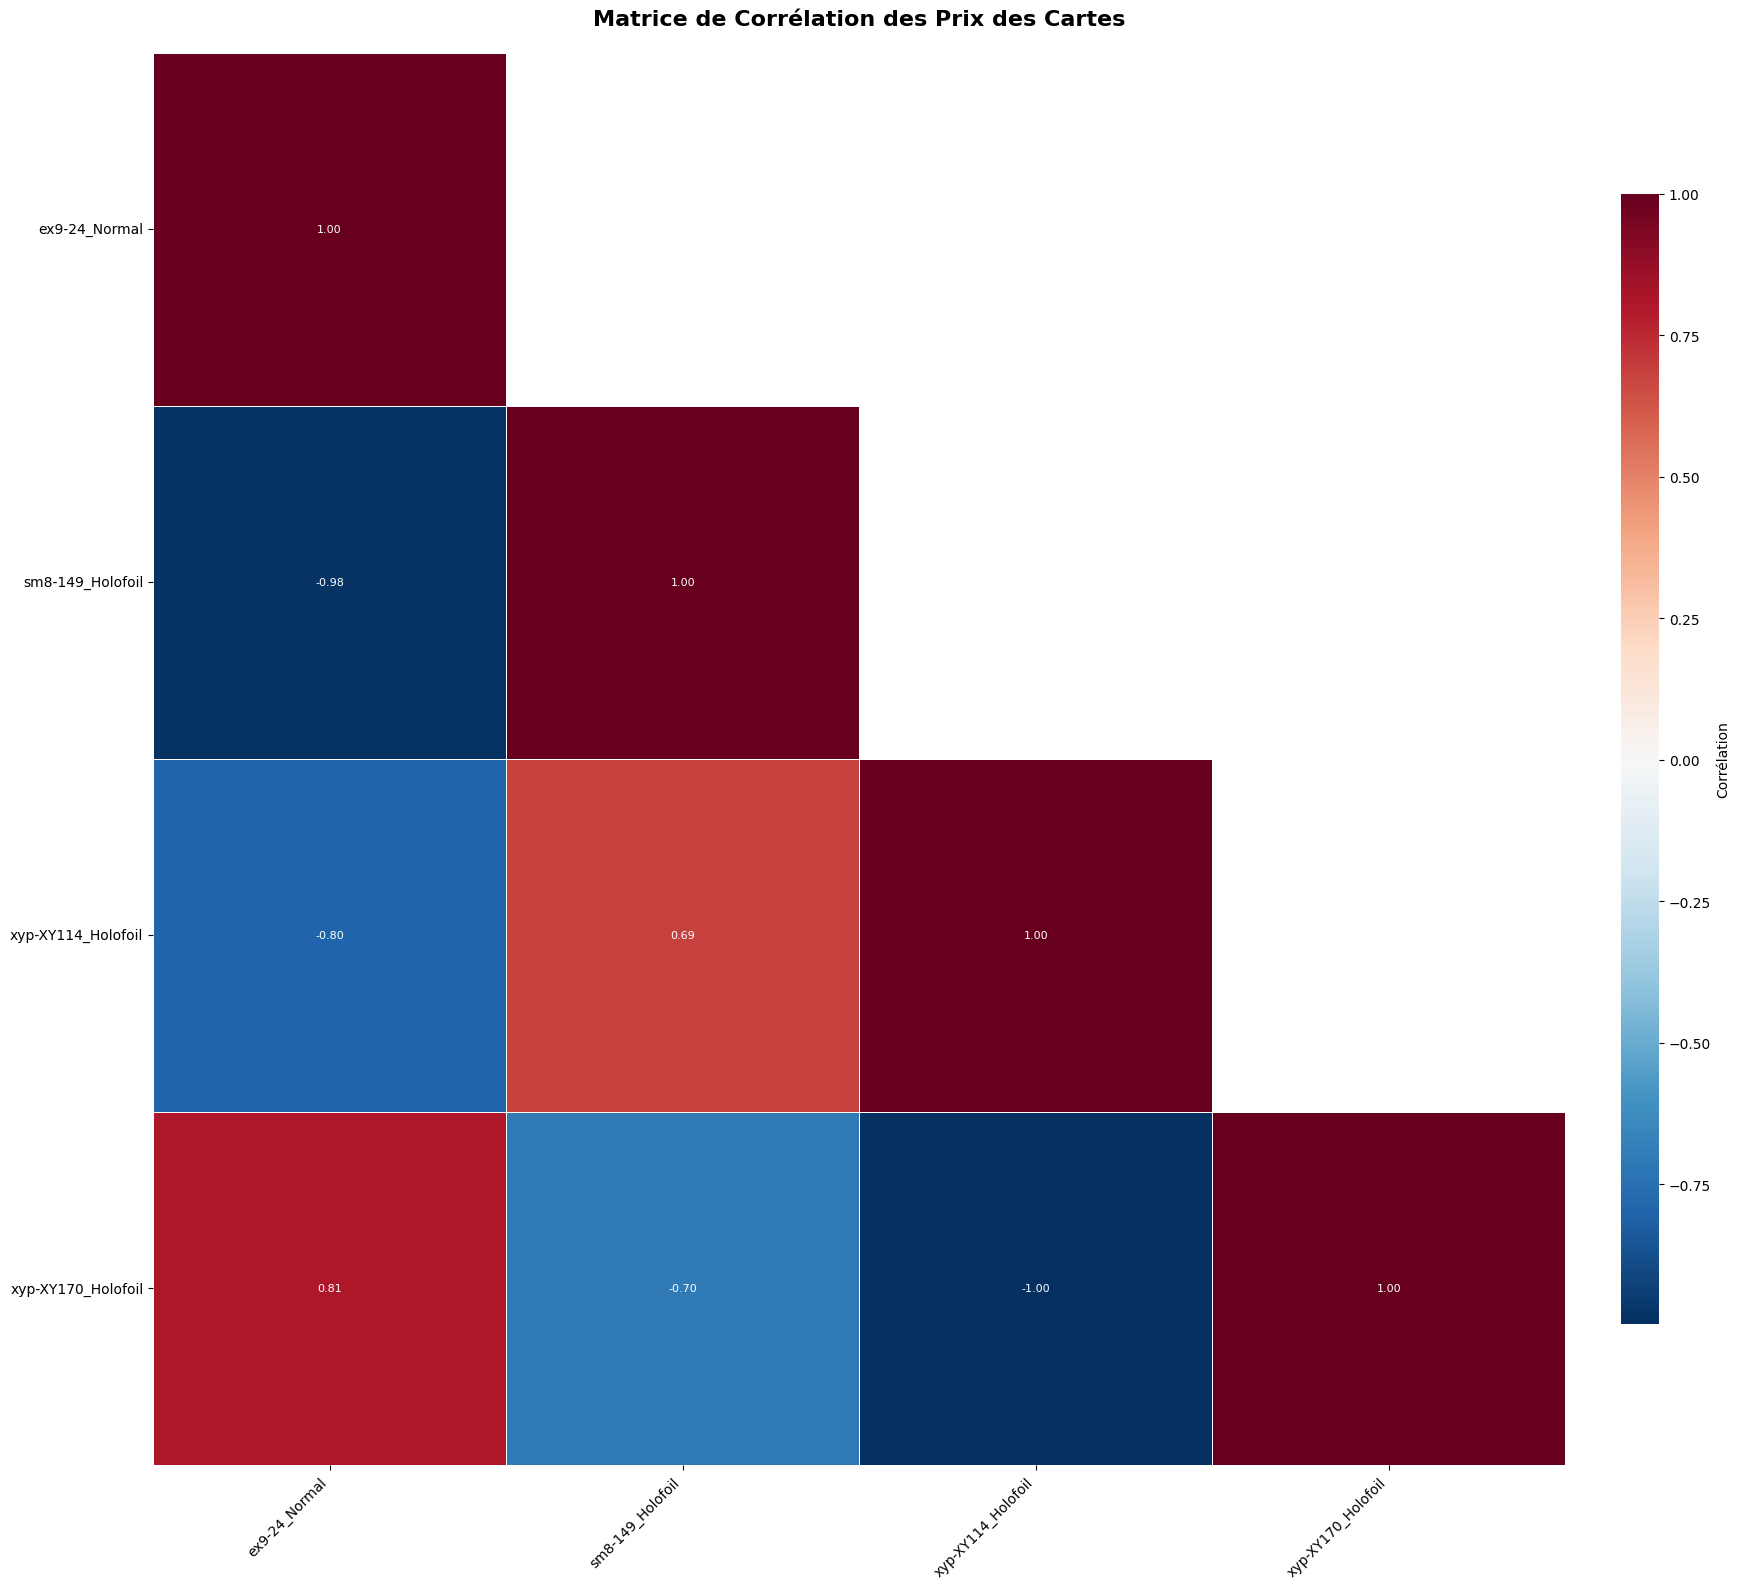

In [93]:
plot_covariance_heatmap(cov)

In [10]:
filtered=markowitz.get_optimized_return_mean_matrix_fiability()

In [11]:
filtered

,card_id,last_price,mean_return,fiability,fiability_dot_return
6,sm7-181_Holofoil,5.89,0.02,0.999980,0.020000
12,xyp-XY114_Holofoil,6.44,0.14,1.000000,0.140000
20,sm6-143_Holofoil,35.88,0.06,0.999254,0.059955
22,ex13-106_Holofoil,7.91,0.04,1.000000,0.040000
30,xy6-101_Holofoil,14.65,0.02,1.000000,0.020000
32,xyp-XY81_Holofoil,9.89,0.02,1.000000,0.020000
47,sm5-163_Holofoil,21.10,0.03,0.997527,0.029926
49,sm12-22_Holofoil,9.75,0.34,1.000000,0.340000
51,hsp-HGSS15_Holofoil,6.22,0.25,0.858149,0.214537
52,ex9-24_Normal,2.47,0.28,0.858149,0.240282


In [12]:
from MarkowitzPortfolioOptimizer import MarkowitzOptimizer
from UsefulFunctionsForModels import get_dataframe_cards_matrix

In [13]:
path='price_history/high_sales'
amount=100
df=get_dataframe_cards_matrix(path)

Error reading card sm10-130_Holofoil: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte


/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nayelbenabdesadok/opt/anaconda3/envs/pokemon_card/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [14]:
marko=MarkowitzOptimizer(amount_to_invest=amount,dataframe_cards_info=df)

In [15]:
a=marko.optimize_cards_sell()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [16]:
a[0]

99.24000000000001

In [17]:
a[1]

0.0766712396600279

In [18]:
a[2]

,card_id,last_price,mean_return,fiability,fiability_dot_return
52,ex9-24_Normal,2.47,0.28,0.858149,0.240282
111,sm8-149_Holofoil,5.46,0.03,1.000000,0.030000
96,xyp-XY170_Holofoil,7.35,0.02,0.993940,0.019879
6,sm7-181_Holofoil,5.89,0.02,0.999980,0.020000
12,xyp-XY114_Holofoil,6.44,0.14,1.000000,0.140000
122,xyp-XY107_Holofoil,6.74,0.11,1.000000,0.110000
22,ex13-106_Holofoil,7.91,0.04,1.000000,0.040000
47,sm5-163_Holofoil,21.10,0.03,0.997527,0.029926
20,sm6-143_Holofoil,35.88,0.06,0.999254,0.059955


In [1]:
def retrieve_card_names(df, csv="pokemon_cards.csv"):
    for id in df["card_id"] : 
        

IndentationError: expected an indented block (4136163889.py, line 3)

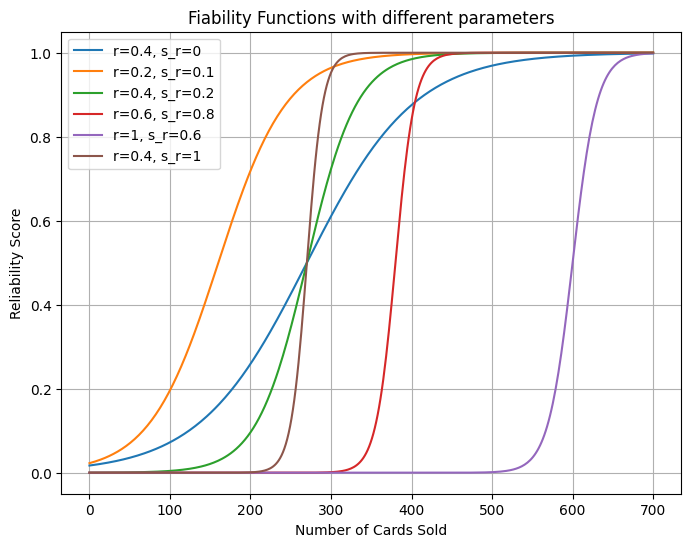

In [11]:
import numpy as np
import matplotlib.pyplot as plt

MAX_K: float = 0.1
MIN_K: float = 0.015

MAX_X0: float = 600
MIN_X0: float = 50

def sigmoid(x: np.ndarray, x0: float, k: float) -> np.ndarray:
    k = (MAX_K - MIN_K) * k + MIN_K
    x0 = (MAX_X0 - MIN_X0) * x0 + MIN_X0
    return 1 / (1 + np.exp(-k * (x - x0)))

# Générer les valeurs de x
x = np.linspace(0, 700, 400)

# Différentes configurations de paramètres
paramètres = [
    {"r": 0.4, "s_r": 0, "label": "r=0.4, s_r=0"},
    {"r": 0.2, "s_r": 0.1, "label": "r=0.2, s_r=0.1"},
    {"r": 0.4, "s_r": 0.2, "label": "r=0.4, s_r=0.2"},
    {"r": 0.6, "s_r": 0.8, "label": "r=0.6, s_r=0.8"},
    {"r": 1, "s_r": 0.6, "label": "r=1, s_r=0.6"},
    {"r": 0.4, "s_r": 1, "label": "r=0.4, s_r=1"}
]

# Créer un graphique pour chaque configuration
plt.figure(figsize=(8, 6))
for params in paramètres:
    y = sigmoid(x, x0=params["r"], k=params["s_r"])
    plt.plot(x, y, label=params["label"])

# Ajouter des détails au graphique
plt.title("Fiability Functions with different parameters")
plt.xlabel("Number of Cards Sold")
plt.ylabel("Reliability Score")
plt.grid(True)
plt.legend()
plt.show()
